# Bayes by backprop

This reading is a review of the _Bayes by backprop_ method for quantifying epistemic uncertainty in a neural network model.

In [1]:
from IPython.display import Image

## Introduction

This reading discusses one way to introduce weight uncertainty into neural networks. It will describe the *Bayes by Backprop* method introduced in this paper:

- Charles Blundell, Julien Cornebise, Koray Kavukcuoglu, Daan Wierstra. [Weight uncertainty in neural networks](https://arxiv.org/pdf/1505.05424.pdf). In *Proceedings of the 32nd International Conference on Machine Learning*.

The main idea is as follows. In a traditional neural network, as shown in the left figure below, each weight has a single value. The true value of this weight is not certain. A lot of this uncertainty comes from imperfect training data, which does not exactly describe the distribution the data were drawn from.

As an analogy, consider the problem of determining the population average height by measuring 100 randomly selected people. An estimate of the population mean is then the mean calculated across these 100. However, this is just an estimate; we may, by chance, have selected 100 people that are slightly taller than expected, or shorter. Recall that this is called *epistemic* uncertainty, and we expect it to decrease as the amount of training data increases. For example, the uncertainty on an estimate obtained using 100 people is larger than one using 10,000 people.

In this reading, we want to include such uncertainty in deep learning models. This is done by changing each weight from a single deterministic value to a *probability distribution*. We then learn the parameters of this distribution. Consider a neural network weight $w_i$. In a standard (deterministic) neural network, this has a single value $\hat{w}_i$, learnt via backpropagation. In a neural network with weight uncertainty, each weight is represented by a probability distribution, and the *parameters* of this distribution are learned via backpropagation. Suppose, for example, that each weight has a normal distribution. This has two parameters: a mean $\mu_i$ and a standard deviation $\sigma_i$.
- Classic deterministic NN: $w_i = \hat{w}_i$
- NN with weight uncertainty represented by normal distribution: $w_i \sim N(\hat{\mu}_i, \hat{\sigma}_i)$.

An image of the situation, provided in the paper, is as follows.


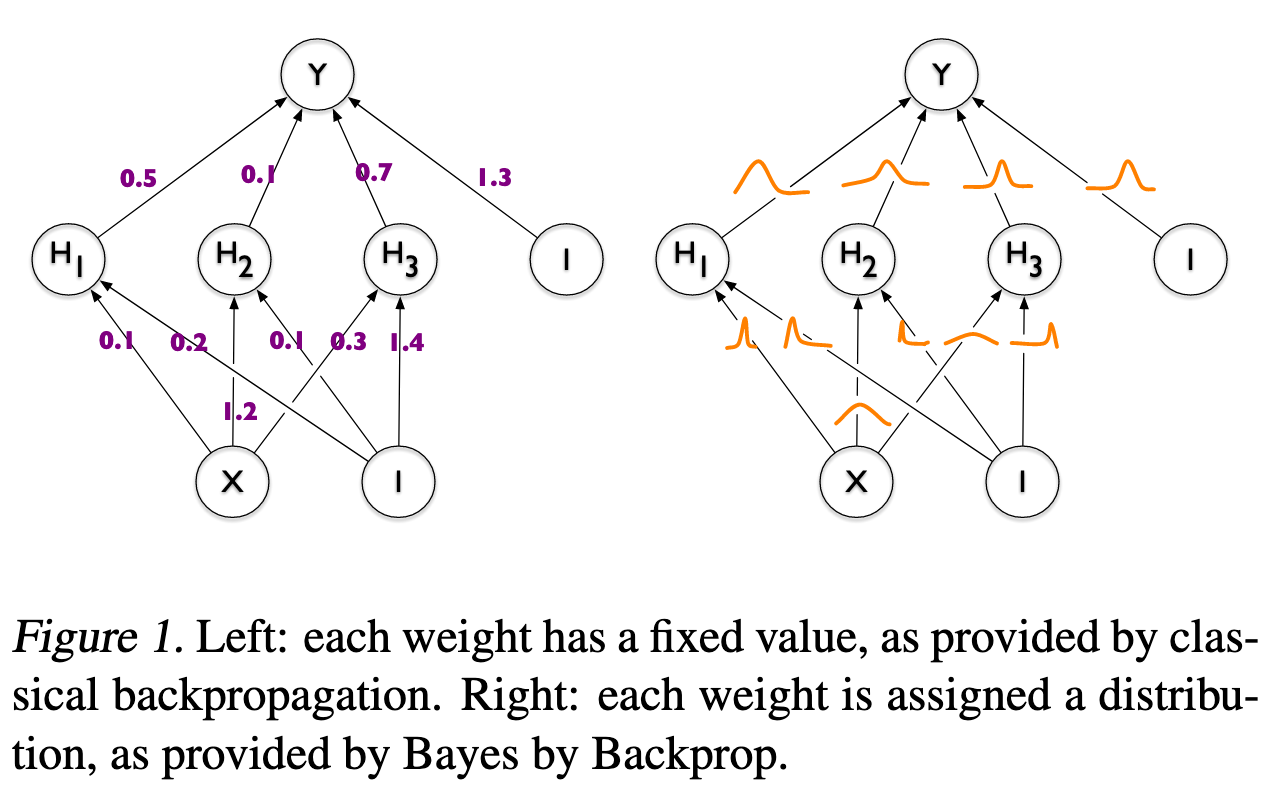

In [2]:
# Run this cell to download and view a figure from the original paper to sketch a Bayesian NN

!wget -q -O bayesian_nn.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1mxY3CU32ia0VJZYjfXpRv8021PkYFu0h"
Image("bayesian_nn.png", width=600)

Since the weights are uncertain, the feedforward value of some input $x_i$ is not constant. A single feedforward value is determined in two steps:
1. Sample each network weight from their respective distributions -- this gives a single set of network weights.
2. Use these weights to determine a feedforward value $\hat{y}_i$.

Hence, the key question is how to determine the parameters of the distribution for each network weight. The paper introduces exactly such a scheme, called *Bayes by Backprop*. The details are discussed in the remainder of this reading.

## Bayesian learning

**Note**: In this reading, we use the notation $P$ to refer to a probability density. For simplicity, we'll only consider continuous distributions (which have a density). In the case of discrete distributions, $P$ would represent a probability mass and integrals should be changed to sums. However, the formulae are the same.

*Bayesian* methods represent one common framework in which to conduct statistical inference. We only provide a very short introduction here, but for a more detailed account of Bayesian inference you could read the [Wikipedia article](https://en.wikipedia.org/wiki/Bayesian_inference) and references therein. 

What you need to know now is that Bayesian methods can be used to calculate the distribution of a model parameter given some data. In the context of weight uncertainty in neural networks, this is convenient, since we are looking for the distribution of weights (model parameters) given some (training) data. The key step relies on Bayes' theorem. This theorem states, in mathematical notation, that

$$ P(w | D) = \frac{P(D | w) P(w)}{\int P(D | w') P(w') \text{d}w'} $$

where the terms mean the following:
- $D$ is some data, e.g. $x$ and $y$ value pairs: $D = \{(x_1, y_1), \ldots, (x_n, y_n)\}$. This is sometimes called the *evidence*.
- $w$ is the value of a model weight.
- $P(w)$ is called the *prior*. This is our "prior" belief on the probability density of a model weight, i.e. the distribution that we postulate before seeing any data.
- $P(D | w)$ is the *likelihood* of having observed data $D$ given weight $w$. It is precisely the same likelihood we discussed in the previous reading and is used to calculate the negative log-likelihood.
- $P(w | D)$ is the *posterior* density of the distribution of the model weight at value $w$, given our training data.  It is called *posterior* since it represents the distribution of our model weight *after* taking the training data into account.

Note that the term ${\int P(D | w') P(w') \text{d}w'} = P(D)$ does not depend on $w$ (as the $w'$ is an integration variable). It is only a normalisation term. For this reason, we will from this point on write Bayes' theorem as

$$ P(w | D) = \frac{P(D | w) P(w)}{P(D)}. $$

Bayes' theorem gives us a way of combining data with some "prior belief" on model parameters to obtain a distribution for these model parameters that considers the data, called the *posterior distribution*.

## Bayesian neural network with weight uncertainty --  in principle

The above formula gives a way to determine the distribution of each weight in the neural network:
1. Pick a prior density $P(w)$.
2. Using training data $D$, determine the likelihood $P(D | w)$.
3. Determine the posterior density $P(w | D)$ using Bayes' theorem. This is the distribution of the NN weight.

While this works in principle, in many practical settings it is difficult to implement. The main reason is that the normalisation constant ${\int P(D | w') P(w') \text{d}w'} = P(D)$ may be very difficult to calculate, as it involves solving or approximating a complicated integral. For this reason, approximate methods, such as *Variational Bayes* described below, are often employed.

## Variational Bayes

*Variational Bayes* methods approximate the posterior distribution with a second function, called a *variational posterior*. This function has a known functional form, and hence avoids the need to determine the posterior $P(w | D)$ exactly. Of course, approximating a function with another one has some risks, since the approximation may be very bad, leading to a posterior that is highly inaccurate. In order to mediate this, the variational posterior usually has a number of parameters, denoted by $\theta$, that are tuned so that the function approximates the posterior as well as possible. Let's see how this works below. 

Instead of $P(w | D)$, we assume the network weight has density $q(w | \theta)$, parameterized by $\theta$. $q(w | \theta)$ is known as the *variational posterior*. We want $q(w | \theta)$ to approximate $P(w | D)$, so we want the "difference" between $q(w | \theta)$ and $P(w | D)$ to be as small as possible. This "difference" between the two distributions is usually measured by the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) $D_{\text{KL}}$ (note that this is **unrelated** to the $D$ we use to denote the data). The Kullback-Leibler divergence between two distributions with densities $f(x)$ and $g(x)$ respectively is defined as

$$
D_{KL} (f(x) || g(x)) = \int f(x) \log \left( \frac{f(x)}{g(x)} \right) \text{d} x.
$$

Note that this function has value 0 (indicating no difference) when $f(x) \equiv g(x)$, which is the result we expect. We use the convention that $\frac{0}{0} = 1$ here.


Viewing the data $D$ as a constant, the Kullback-Leibler divergence between $q(w | \theta)$ and $P(w | D)$ is hence

$$
\begin{align}
D_{KL} (q(w | \theta) || P(w | D)) &= \int q(w | \theta) \log \left( \frac{q(w | \theta)}{P(w | D)} \right) \text{d} w \\
&= \int q(w | \theta) \log \left( \frac{q(w | \theta) P(D)}{P(D | w) P(w)} \right) \text{d} w \\
&= \int q(w | \theta) \log P(D) \text{d} w + \int q(w | \theta) \log \left( \frac{q(w | \theta)}{P(w)} \right) \text{d} w - \int q(w | \theta) \log P(D | w) \text{d} w \\
&= \log P(D) + D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w))
\end{align}
$$

where, in the last line, we have used $\int q(w | \theta) \log P(D) \text{d}w = \log P(D) \int q(w | \theta) \text{d} w = \log P(D)$ since $q(w | \theta)$ is a probability distribution and hence integrates to 1. If we consider the data $D$ to be constant, the first term is a constant also, and we may ignore it when minimising the above. Hence, we are left with the function

$$
\begin{align}
L(\theta | D) &= D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w))
\end{align}
$$

Note that this function depends only on $\theta$ and $D$, since $w$ is an integration variable. This function has a nice interpretation as the sum of:
- The Kullback-Leibler divergence between the variational posterior $q(w | \theta)$ and the prior $P(w)$. This is called the *complexity cost*, and it depends on $\theta$ and the prior but not the data $D$.
- The expectation of the negative loglikelihood $\log P(D | w)$ under the variational posterior $q(w | \theta)$. This is called the *likelihood cost* and it depends on $\theta$ and the data but not the prior.

$L(\theta | D)$ is the loss function that we minimise to determine the parameter $\theta$. Note also from the above derivation, that we have

$$
\begin{align}
\log P(D) &= \mathbb{E}_{q(w | \theta)}(\log P(D | w)) - D_{KL} ( q(w | \theta) || P(w) ) + D_{KL} (q(w | \theta) || P(w | D))\\
&\ge \mathbb{E}_{q(w | \theta)}(\log P(D | w)) - D_{KL} ( q(w | \theta) || P(w) ) =: ELBO
\end{align}
$$

which follows because $D_{KL} (q(w | \theta) || P(w | D))$ is nonnegative. The final expression on the right hand side is therefore a lower bound on the log-evidence, and is called the *evidence lower bound*, often shortened to *ELBO*. The ELBO is the negative of our loss function, so minimising the loss function is equivalent to maximising the ELBO.

Maximising the ELBO requires a tradeoff between the KL term and expected log-likelihood term. On the one hand, the divergence between $q(w | \theta)$ and $P(w)$ should be kept small, meaning the variational posterior shouldn't be too different to the prior. On the other, the variational posterior parameters should maximise the expectation of the log-likelihood $\log P(D | w)$, meaning the model assigns a high likelihood to the data.

## A backpropagation scheme

### The idea

We can use the above ideas to create a neural network with weight uncertainty, which we will call a *Bayesian neural network*. From a high level, this works as follows. Suppose we want to determine the distribution of a particular neural network weight $w$. 

1. Assign the weight a prior distribution with density $P(w)$, which represents our beliefs on the possible values of this network before any training data. This may be something simple, like a unit Gaussian. Furthermore, this prior distribution will usually not have any trainable parameters.
2. Assign the weight a variational posterior with density $q(w | \theta)$ with some trainable parameter $\theta$. 
3. $q(w | \theta)$ is the approximation for the weight's posterior distribution. Tune $\theta$ to make this approximation as accurate as possible as measured by the ELBO.

The remaining question is then how to determine $\theta$. Recall that neural networks are typically trained via a backpropagation algorithm, in which the weights are updated by perturbing them in a direction that reduces the loss function. We aim to do the same here, by updating $\theta$ in a direction that reduces $L(\theta | D)$. 

Hence, the function we want to minimise is 

$$
\begin{align}
L(\theta | D) &= D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w)) \\
&= \int q(w | \theta) ( \log q(w | \theta) - \log P(D | w) - \log P(w) ) \text{d}w.
\end{align}
$$

In principle, we could take derivatives of $L(\theta | D)$ with respect to $\theta$ and use this to update its value. However, this involves doing an integral over $w$, and this is a calculation that may be impossible or very computationally expensive. Instead, we want to write this function as an expectation and use a Monte Carlo approximation to calculate derivatives. At present, we can write this function as 

$$
\begin{align}
L(\theta | D) &= \mathbb{E}_{q(w | \theta)} ( \log q(w | \theta) - \log P(D | w) - \log P(w) ).
\end{align}
$$

However, taking derivatives with respect to $\theta$ is difficult because the underlying distribution the expectation is taken with respect to depends on $\theta$. One way we can handle this is with the *reparameterization trick*.

### The reparameterization trick

The reparameterization trick is a way to move the dependence on $\theta$ around so that an expectation may be taken independently of it. It's easiest to see how this works with an example. Suppose $q(w | \theta)$ is a Gaussian, so that $\theta = (\mu, \sigma)$. Then, for some arbitrary $f(w; \mu, \sigma)$, we have

$$
\begin{align}
\mathbb{E}_{q(w | \mu, \sigma)} (f(w; \mu, \sigma) ) &= \int q(w | \mu, \sigma) f(w; \mu, \sigma) \text{d}w \\
&= \int \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2 \sigma^2} (w - \mu)^2 \right) f(w; \mu, \sigma) \text{d}w \\
&= \int \frac{1}{\sqrt{2 \pi}} \exp \left( -\frac{1}{2} \epsilon^2 \right) f \left( \mu + \sigma \epsilon; \mu, \sigma \right) \text{d}\epsilon \\
&= \mathbb{E}_{\epsilon \sim N(0, 1)} (f \left( \mu + \sigma \epsilon; \mu, \sigma \right) )
\end{align}
$$

where we used the change of variable $w = \mu + \sigma \epsilon$. Note that the dependence on $\theta = (\mu, \sigma)$ is now only in the integrand and we can take derivatives with respect to $\mu$ and $\sigma$:

$$
\begin{align}
\frac{\partial}{\partial \mu} \mathbb{E}_{q(w | \mu, \sigma)} (f(w; \mu, \sigma) ) &= \frac{\partial}{\partial \mu} \mathbb{E}_{\epsilon \sim N(0, 1)} (f \left( w; \mu, \sigma \right) ) = \mathbb{E}_{\epsilon \sim N(0, 1)} \frac{\partial}{\partial \mu} f \left( \mu + \sigma \epsilon; \mu, \sigma \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial}{\partial \sigma} \mathbb{E}_{q(w | \mu, \sigma)} (f(w; \mu, \sigma) ) &= \frac{\partial}{\partial \sigma} \mathbb{E}_{\epsilon \sim N(0, 1)} (f \left( w; \mu, \sigma \right) ) = \mathbb{E}_{\epsilon \sim N(0, 1)} \frac{\partial}{\partial \sigma} f \left( \mu + \sigma \epsilon; \mu, \sigma \right)
\end{align}
$$

Finally, note that we can approximate the expectation by its Monte Carlo estimate:

$$
\begin{align}
\mathbb{E}_{\epsilon \sim N(0, 1)}  \frac{\partial}{\partial \theta} f \left( \mu + \sigma \epsilon; \mu, \sigma \right) \approx \sum_{i}  \frac{\partial}{\partial \theta} f \left( \mu + \sigma \epsilon_i; \mu, \sigma \right),\qquad \epsilon_i \sim N(0, 1).
\end{align}
$$

The above reparameterization trick works in cases where we can write the $w = g(\epsilon, \theta)$, where the distribution of the random variable $\epsilon$ is independent of $\theta$.

### Implementation

Putting this all together, for our loss function $L(\theta | D) \equiv L(\mu, \sigma | D)$, we have 

$$
f(w; \mu, \sigma) = \log q(w | \mu, \sigma) - \log P(D | w) - \log P(w)
$$

$$
\begin{align}
\frac{\partial}{\partial \mu} L(\mu, \sigma | D) \approx \sum_{i} \left( \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} + \frac{\partial f(w_i; \mu, \sigma)}{\partial \mu} \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial}{\partial \sigma} L(\mu, \sigma | D) \approx \sum_{i} \left( \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} \sigma + \frac{\partial f(w_i; \mu, \sigma)}{\partial \sigma} \right)
\end{align}
$$

$$
f(w; \mu, \sigma) = \log q(w | \mu, \sigma) - \log P(D | w) - \log P(w)
$$

where $w_i = \mu + \sigma \epsilon_i, \, \epsilon_i \sim N(0, 1)$. In practice, we often only take a single sample $\epsilon_1$ for each training point. This leads to the following backpropagation scheme:
1. Sample $\epsilon_i \sim N(0, 1)$.
2. Let $w_i = \mu + \sigma \epsilon_i$
3. Calculate 
$$
\nabla_{\mu}f = \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} + \frac{\partial f(w_i; \mu, \sigma)}{\partial \mu} \hspace{3em} \nabla_{\sigma}f = \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} \sigma + \frac{\partial f(w_i; \mu, \sigma)}{\partial \sigma}
$$
4. Update the parameters with some gradient-based optimiser using the above gradients.

This is how we learn the parameters of the distribution for each neural network weight.

### Minibatches

Note that the loss function (or negative of the ELBO) is 

$$
\begin{align}
L(\theta | D) &= D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w)) \\
& = D_{KL} ( q(w | \theta) || P(w) ) - \sum_{j=1}^N \log P(y_j, x_j | w_j)
\end{align}
$$

where $j$ runs over all the data points in the training data ($N$ in total) and $w_j = \mu + \sigma \epsilon_j$ is sampled using $\epsilon_j \sim N(0, 1)$ (we assume a single sample from the approximate posterior per data point for simplicity).

If training occurs in minibatches of size $B$, typically much smaller than $N$, we instead have a loss function

$$
\begin{align}
D_{KL} ( q(w | \theta) || P(w) ) - \sum_{j=1}^{B} \log P(y_j, x_j | w_j).
\end{align}
$$

Note that the scaling factors between the first and second terms have changed, since before the sum ran from 1 to $N$, but it now runs from 1 to $B$. To correct for this, we should add a correction factor $\frac{N}{B}$ to the second term to ensure that its expectation is the same as before. This leads to the loss function, after dividing by $N$ to take the average per training value, of

$$
\begin{align}
\frac{1}{N} D_{KL} ( q(w | \theta) || P(w) ) - \frac{1}{B} \sum_{j=1}^{B} \log P(y_j, x_j | w_j).
\end{align}
$$

By default, when Tensorflow calculates the loss function, it calculates the average across the minibatch. Hence, it already uses the factor $\frac{1}{B}$ present on the second term. However, it does not, by default, divide the first term by $N$. In an implementation, we will have to specify this. You'll see in the next lectures and coding tutorials how to do this.

### Conclusion

This reading introduces the *Bayes by Backpropagation* method, which can be used to embed weight uncertainty into neural networks. Good job getting through it, as the topic is rather advanced. This approach allows the modelling of *epistemic* uncertainty on the model weights. We expect that, as the number of training points increases, the uncertainty on the model weights decreases. This can be shown to be the case in many settings. In the next few lectures and coding tutorials, you'll learn how to apply these methods to your own models, which will make the idea much clearer.

### Further reading and resources

* Bayes by backprop paper: https://arxiv.org/pdf/1505.05424.pdf
* Wikipedia article on Bayesian inference: https://en.wikipedia.org/wiki/Bayesian_inference